## Grupo 2: Análisis de reservas y cancelaciones hoteleras: patrones y predicciones
🎯 Objetivo del proyecto
Analizar los datos de reservas de hoteles para comprender el perfil de los clientes, identificar patrones de comportamiento (estacionalidad, duración de la estancia, precios) y estudiar los factores que influyen en las cancelaciones, utilizando herramientas de análisis de datos en Python.

### 1. Introducción y descripción del dataset

- Breve explicación del contexto del análisis

- Descripción de las variables disponibles

- Objetivo del estudio

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('hotel_bookings.csv')

### 2. Perfil general de las reservas (Patri)

Objetivo: Entender cómo son las reservas y los clientes en general.

Tareas:

* Limpieza y descripción del dataset: tipos de datos, valores nulos, duplicados.
* Análisis de variables descriptivas:

  * *Tipo de hotel* (city vs. resort).
  * *Número de huéspedes* (adultos, niños, bebés).
  * *Países de origen*: top 10 países.
  * *Canales de reserva* (agencias online, offline, directas).
* Visualizaciones:

  * Gráfico de barras comparando city hotel vs resort hotel.
  * Gráfico circular de canales de reserva.
  * Mapa mundial con procedencia de clientes.

### Preguntas a responder:

* ¿Cuál es el perfil típico de cliente?
* ¿Qué países aportan más reservas?
* ¿Por qué canales se reserva más?

In [7]:
print("--- Primeras 5 filas ---")
print(df.head())

print("\n--- Información general y tipos de datos ---")
df.info()

print("\n--- Resumen estadístico de las columnas numéricas ---")
print(df.describe())

print("\n--- Cuántos datos nulos hay ---")
print(df.isnull().sum())

# Pero esto es más informativo:
print(f"Total de filas: {len(df)}")
print(f"Filas únicas: {len(df.drop_duplicates())}")

duplicados_df = df[df.duplicated(keep='first')]
print(f"\nPrimeras filas marcadas como duplicadas:")
print(duplicados_df.head())

--- Primeras 5 filas ---
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ..

Mirar por qué con size() sale bien y con value_counts() no

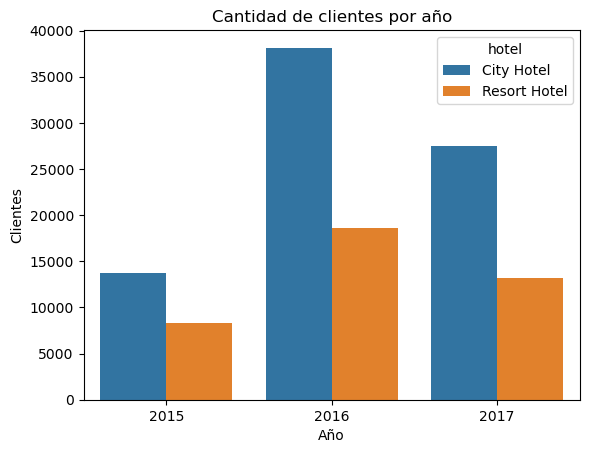

In [ ]:
clientes_hotel_anio = df.groupby(['arrival_date_year', 'hotel']).size().reset_index(name='cantidad_clientes')

sns.barplot(data=clientes_hotel_anio, x='arrival_date_year', y='cantidad_clientes', hue='hotel')
plt.title('Cantidad de clientes por año')
plt.xlabel('Año')
plt.ylabel('Clientes')
plt.show()

Número de países distintos: hotel
City Hotel      166
Resort Hotel    125
Name: country, dtype: int64
hotel         country
City Hotel    PRT        30960
              FRA         8804
              DEU         6084
              GBR         5315
              ESP         4611
                         ...  
Resort Hotel  TGO            1
              TUN            1
              UGA            1
              UZB            1
              ZMB            1
Name: count, Length: 291, dtype: int64


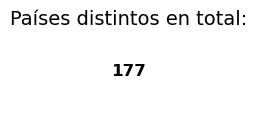

In [ ]:
count_paises = df['country'].nunique()

reservas_por_pais = df.groupby('hotel')['country'].value_counts()
print(reservas_por_pais)

# Crear figura
fig, ax = plt.subplots(figsize=(2, 1))
ax.axis('off')  # Ocultar ejes

# Mostrar texto
ax.text(0.5, 0.5, count_paises, ha='center', va='center', fontsize=12, fontweight='bold')

plt.title("Países distintos en total:", fontsize=14)
plt.show()

Número de países distintos: hotel
City Hotel      166
Resort Hotel    125
Name: country, dtype: int64


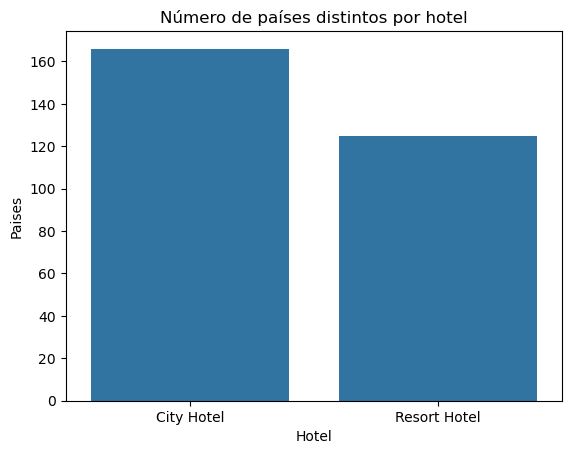

In [ ]:
num_paises = df.groupby('hotel')['country'].nunique()

sns.barplot(x=num_paises.index, y=num_paises.values)
plt.title('Número de países distintos por hotel')
plt.xlabel('Hotel')
plt.ylabel('Paises')
plt.show()

In [40]:
import plotly.express as px

for hotel in df['hotel'].unique():
    reservas_hotel = df[df['hotel']==hotel]['country'].value_counts().reset_index()
    reservas_hotel.columns = ['country', 'reservas']
    
    fig = px.choropleth(
        reservas_hotel,
        locations='country',
        color='reservas',
        color_continuous_scale='Blues',
        title=f'Reservas por país - {hotel}'
    )
    fig.show()

distribution_channel
TA/TO        97870
Direct       14645
Corporate     6677
GDS            193
Undefined        5
Name: count, dtype: int64


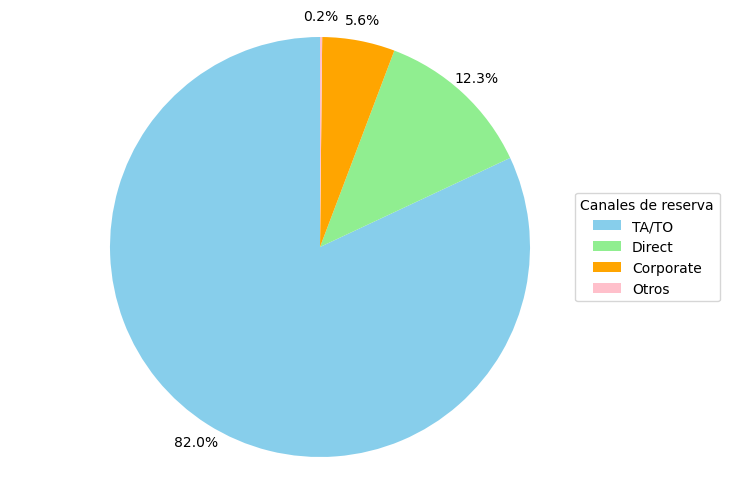

In [19]:
canales = df['distribution_channel'].value_counts()
print(canales)

# Umbral: menos del 5% se agrupa en 'Otros'
umbral = 0.05 * canales.sum()
canales_agrupados = canales.copy()
canales_agrupados[canales < umbral] = 0  # asignar 0 temporalmente

otros = canales[canales < umbral].sum()
canales_agrupados = canales_agrupados[canales_agrupados>0]
canales_agrupados['Otros'] = otros

plt.figure(figsize=(8, 6))
# Crear gráfico circular
wedges, texts, autotexts = plt.pie(
    canales_agrupados.values,
    labels=None,          # etiquetas en la leyenda, no en el gráfico
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue','lightgreen','orange','pink'],
    pctdistance=1.1      # porcentaje dentro pero más separado
)

# Agregar leyenda al lado
plt.legend(
    wedges,                 # los "trozos" del pie
    canales_agrupados.index,          # nombres de los canales
    title="Canales de reserva",
    loc="center left",
    bbox_to_anchor=(0.9, 0, 0.5, 1)
)

plt.axis('equal')
plt.show()

### 3. Patrones de comportamiento y cancelaciones (Rodri)

Objetivo: Analizar cómo varían las reservas en función del tiempo, los precios y la estancia.

Tareas:

* Estudiar variables clave:

  * *Mes y año de llegada* → estacionalidad.
  * *Duración de la estadía* (noches de semana y fin de semana).
  * *Precio promedio por noche (adr)* → variación según temporada.
  * *Cancelaciones*: proporción general y por segmento.
* Visualizaciones:

  * Línea temporal con reservas por mes.
  * Boxplot de precios según temporada alta/baja.
  * Gráfico de barras: cancelaciones por canal de reserva.

### Preguntas a responder:

* ¿En qué meses hay más reservas y cancelaciones?
* ¿El precio influye en la probabilidad de cancelación?
* ¿Los hoteles de ciudad o de resort tienen más cancelaciones?


### 4. Predicción y recomendaciones (Albert)

Objetivo: Explorar qué factores están más relacionados con las cancelaciones y proponer conclusiones prácticas.

Tareas:

* Crear variables comparativas:

  * Reservas canceladas vs no canceladas.
  * Relación entre lead_time (antelación de reserva) y cancelación.
  * Clientes repetidores vs nuevos.
* Visualizaciones:

  * Heatmap de correlaciones entre variables numéricas y cancelación.
  * Gráfico de barras de cancelación según país.
  * Boxplot de lead_time para canceladas vs no canceladas.
* (Opcional avanzado) Entrenar un modelo simple de clasificación para predecir cancelaciones (ej: logistic regression, random forest).

### Preguntas a responder:

* ¿Qué variables son más importantes para explicar una cancelación?
* ¿Se pueden detectar patrones que ayuden a los hoteles a reducir cancelaciones?
* ¿Qué recomendaciones se pueden dar a un hotel basadas en el análisis?